# Quantum Phase Estimation (QPE)


* [Qiskit Chapter on QPE](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)



### Example T-gate

Let’s take a gate we know well, the $T$-gate, and use Quantum Phase Estimation to estimate its phase. You will remember that the $T$-gate adds a phase of $e^\frac{i\pi}{4}$ to the state $|1\rangle$:

$$ T|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Since QPE will give us $\theta$ where:

$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$

We expect to find:

$$\theta = \frac{1}{8}$$

In this example we will use three qubits and obtain an _exact_ result (not an estimation!)


In [1]:
import numpy as np
import pylab as plt

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector


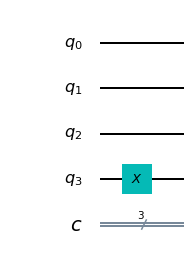

In [2]:
qpe = QuantumCircuit(4,3)
qpe.x(3)
qpe.draw('mpl')

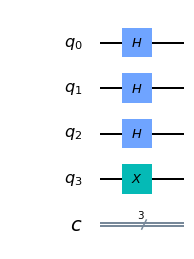

In [3]:
#Apply Hadamard gate to all the quits
for q in range(3):
    qpe.h(q)
qpe.draw('mpl')

Next we perform the controlled unitary operations. Remember: Qiskit orders its qubits the opposite way round to the image above.

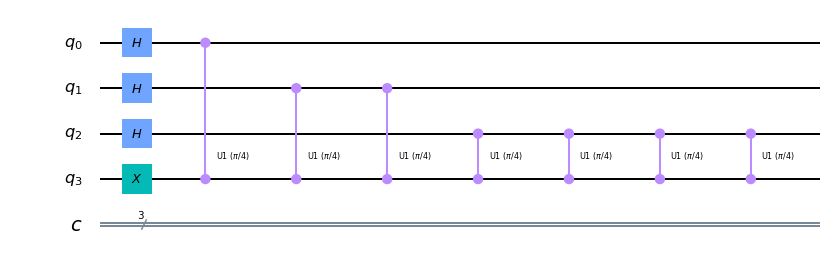

In [4]:
repetitions = 1
for q in range(3):
    for i in range(repetitions):
        qpe.cu1(np.pi/4., q, 3) # controlled U gate : for T gate angle = pi/4
    repetitions *= 2
qpe.draw('mpl')

We apply the inverse quantum Fourier transformation to convert the state of the counting register. Here we provide the code for  𝑄𝐹𝑇† :

In [5]:
from qiskit.circuit.library import QFT

In [6]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in the circuit qc"""
    for q in range(n//2):
        qc.swap(q, n-q-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/(float(2**(j-m))), m, j)
        qc.h(j)

def qft_dagger2(qc, n):
    """n-qubit QFTdagger the first n qubits in the circuit qc"""
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    gate = QFT(n, inverse=True, do_swaps=True )
    qc.append(gate, range(n))
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END


In [7]:
# measure the counting register

qpe.barrier()
qft_dagger(qpe, 3)
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

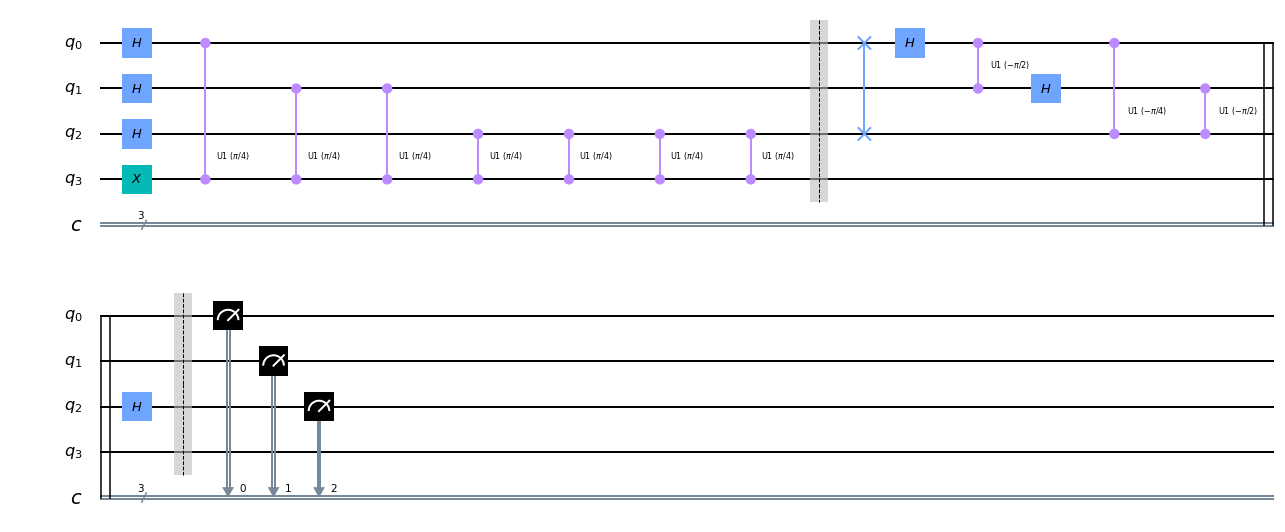

In [8]:
qpe.draw('mpl')

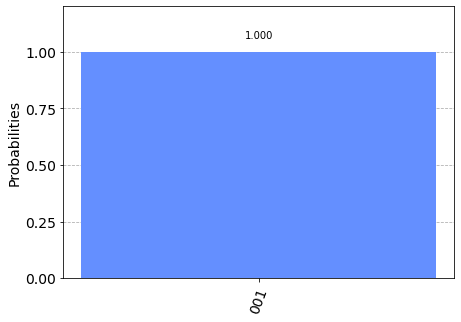

In [9]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get one result $(001)$ with certainty, which translates to the decimal: 1. We now need to divide our result (1) by  $2^n$  to get  $\theta$ :

$$
\theta=\frac{1}{2^3}=\frac{1}{8}
$$

This is exactly the result we expected!


In [10]:
def bin2decimal(binary_str):
    if '1' not in binary_str:
        return 0
    else:        
        binary = int(binary_str.lstrip('0'))

        binary1 = binary
        decimal, i = 0, 0
        while(binary != 0): 
            dec = binary % 10
            decimal = decimal + dec * pow(2, i) 
            binary = binary//10
            i += 1
        return decimal

bin2decimal('001010')

10

binary: 0010 , decimal: 2 Count ratio: 1.0
phase: 0.125
{'0010': 2048}


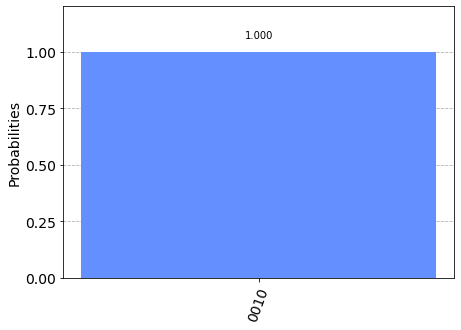

In [11]:
def QPE(N=3):
    qc = QuantumCircuit(N+1, N)
    qc.x(N)
        
    #Apply Hadamard gate to all the quits
    for q in range(N):
        qc.h(q)
    
    #Next we perform the controlled unitary operations
    repetitions = 1
    for q in range(N):
        for i in range(repetitions):
            qc.cu1(np.pi/4., q, N) # controlled U gate, angle is pi/4 for T gate
        repetitions *=2
       
    # measure the counting register
    qc.barrier()
    qft_dagger(qc, N)
    qc.barrier()
    for n in range(N):
        qc.measure(n,n)

    # execute the circuit
    backend = Aer.get_backend('qasm_simulator')
    Nshots = 2048
    results = execute(qc, backend=backend, shots=Nshots).result()
    counts = results.get_counts()
    
    for binary in counts:
        dec = bin2decimal(binary)
        phase = dec/(2**N)
        print ('binary:', binary,', decimal:', dec, 'Count ratio:', counts[binary]/Nshots)
        print ('phase:', phase)

    return counts
    #print (counts)

counts = QPE(4)
print (counts)

plot_histogram(counts)


Note in the above function: you can change the number of qubits and still get the same phase.

## Example: Getting More Precision

Instead of a  𝑇 -gate, let’s use a gate with  $\theta=\frac{1}{3}$ . We set up our circuit as with the last example


{'00000': 1, '01011': 1390, '10010': 2, '11001': 1, '01111': 9, '00011': 4, '01110': 17, '01001': 68, '00100': 6, '10110': 3, '01101': 26, '11101': 1, '00001': 5, '11011': 2, '10011': 2, '10101': 2, '10001': 6, '11111': 1, '11110': 1, '00110': 7, '01010': 359, '01000': 13, '01100': 90, '10111': 3, '10000': 5, '00111': 15, '10100': 1, '11000': 1, '00101': 5, '11100': 2}
the phase lies between [ 0.34375 , 0.1875 ]


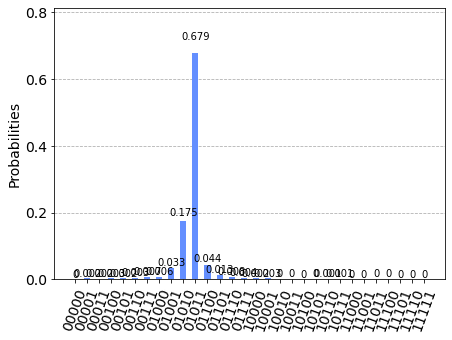

In [12]:
def getting_more_precision(N=3):
    qc = QuantumCircuit(N+1, N)
        
    # Prepare our eigenstate |psi>:
    qc.x(N)
    
    #Apply Hadamard gate to all the quits
    for q in range(N):
        qc.h(q)
    
    #controlled-U operations
    angle = 2*np.pi/3.
    
    repetitions = 1
    for q in range(N):
        for i in range(repetitions):
            qc.cu1(angle, q, N) # controlled U gate
        repetitions *=2
       
    # measure the counting register
    qc.barrier()
    qft_dagger(qc, N)
    qc.barrier()
    for n in range(N):
        qc.measure(n,n)

    # execute the circuit
    backend = Aer.get_backend('qasm_simulator')
    Nshots = 2048
    results = execute(qc, backend=backend, shots=Nshots).result()
    counts = results.get_counts()

    return counts

def calcPhase(counts, Nqubit):
    
    kL = list(counts.items())
    vL = list(counts.values())
    
    maxval1 = max(vL); (k1,v1) = kL[vL.index(maxval1)]; vL.remove(maxval1)
    maxval2 = max(vL); (k2,v2) = kL[vL.index(maxval2)];
    
    k1_dec = bin2decimal(k1)
    k2_dec = bin2decimal(k2)
    
    phase1 = k1_dec/(2**Nqubit)
    phase2 = k2_dec/(2**Nqubit)
    
    print ('the phase lies between [',phase1, ',', phase2, ']')

N=5
counts = getting_more_precision(N)
print (counts)
calcPhase(counts, N)

plot_histogram(counts)


In [13]:
#'11010': 1385
26/32
print ( 6/8, 4/8)

0.75 0.5


In [14]:
d = {'001': 60, '011': 1397, '010': 358}

list(d.keys())[0]

'001'